<a href="https://colab.research.google.com/github/progManu/Advanced-Topics-Machine-Learning/blob/main/EquivarianceMeasureFP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training

In [ ]:
'''
Installation of the LieConv library
'''
!pip install git+https://github.com/mfinzi/LieConv &> /dev/null

In [ ]:
'''
Import of the libry used
'''
import torch
import torchvision

import numpy as np

import math

from lie_conv.lieConv import LieConv
from lie_conv.lieConv import ImgLieResnet
from lie_conv.lieConv import LieResNet
from lie_conv.lieGroups import SO2

import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/ATML/FINAL_PROJECT

Mounted at /content/drive
/content/drive/MyDrive/ATML/FINAL_PROJECT


In [ ]:
'''
Definition of the hook function to save the activation
'''
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
'''
Setting the device to get the GPU usage
'''
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
'''
Creation of the trainloader and testloader
'''
BATCH_SIZE = 25 # 25 sweet spot in example

transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.RandomRotation((-180,180)), # enabled only during training, while on testing I preferred to use fixed rotation
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST('./data/', transform=transforms,  train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = torchvision.datasets.MNIST('./data/', transform=transforms, train=False, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
'''
Model definition:
[num_layers]: equivariant layers
[num_targets]: output number
[group]: SO2(.2) rotation group
[k]: controls the number of neurons in the equivariant layers
'''
model = ImgLieResnet(num_layers=3, num_targets=10, group=SO2(.2), k=128).to(device)

In [ ]:
model

In [ ]:
'''
Load model trainded by me with the parameter specified above: (accuracy: 95% in 5 epochs)
'''

model.load_state_dict(torch.load('3lyr_k128#best.pt'))

<All keys matched successfully>

In [ ]:
'''
Definition of the loss and the optimizer
'''

loss=torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
'''
Definition of accuracy calculator
'''

def get_accuracy_conv(model, dataloader):
    model.eval()
    with torch.no_grad():
        correct=0
        for x, y in iter(dataloader):
            x = x.to(device)
            y = y.to(device)
            out=model(x)
            correct+=(torch.argmax(out, axis=1)==y).sum()
        return correct/len(dataloader.dataset)

In [ ]:
'''
Training loop
'''

epochs=5
losses=[]
for epoch in range(epochs):
    print("Test accuracy: ", get_accuracy_conv(model, testloader))
    model.train()
    print("Epoch: ", epoch)
    for x, y in iter(trainloader):
        x = x.to(device)
        y = y.to(device)
        out=model(x)
        l=loss(out, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        losses.append(l.item())
print("Final accuracy: ", get_accuracy_conv(model, testloader))

# Measures

In [ ]:
'''
Setting up the hook function and saving activations (this as I said above is without random rotations)
'''

model.net[6].module.register_forward_hook(get_activation('classification_out'))
model.net[1].conv.weightnet[8].module.register_forward_hook(get_activation('equivariance_out'))

x, y = next(iter(trainloader))

x = x.to(device)
y = y.to(device)

In [ ]:
'''
Measuring Equivariance
'''

activation = {}

output = model(torchvision.transforms.functional.rotate(x, 90).to(device))

representation_unrotated = torchvision.transforms.functional.rotate(activation['equivariance_out'], -90)

activation = {}

output = model(x)

normal_representation = activation['equivariance_out']

torch.norm(representation_unrotated - normal_representation, p='fro', dim=(1, 2)).mean()

tensor(71.3296, device='cuda:0')

In [ ]:
'''
Definition of the functions to plot images
'''

def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

torch.Size([10, 1, 32, 32])


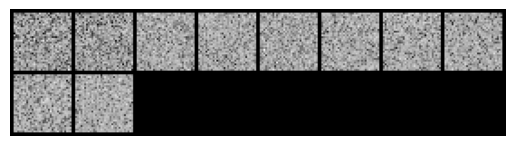

In [ ]:
'''
Plotting weights of the pooling layer
'''

w = model.net[6].module.weight.cpu().detach()

w = w.reshape(w.size()[0], 1, int(math.sqrt(w.size()[1])), int(math.sqrt(w.size()[1])))

print(w.size())


w_min, w_max = w.min(), w.max()
plt_weights = (w - w_min) / (w_max - w_min)

imshow(torchvision.utils.make_grid(plt_weights))

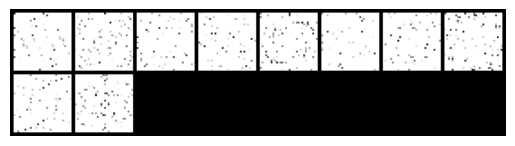

In [ ]:
'''
Plotting the FFT2D of the weights of the pooling layer
'''

w_bfft = model.net[6].module.weight.cpu().detach()

w_bfft_min, w_bfft_max = w_bfft.min(), w_bfft.max()
w_bfft_norm = (w_bfft - w_bfft_min) / (w_bfft_max - w_bfft_min )

plt_weights_fft = w_bfft_norm.reshape(w_bfft_norm.size()[0], 1, int(math.sqrt(w_bfft_norm.size()[1])), int(math.sqrt(w_bfft_norm.size()[1])))

fft_image = torch.fft.fft2(plt_weights_fft)

# Calculate the magnitude spectrum
magnitude_spectrum = torch.abs(torch.fft.fftshift(fft_image))

# Display the magnitude spectrum
imshow(torchvision.utils.make_grid(magnitude_spectrum))

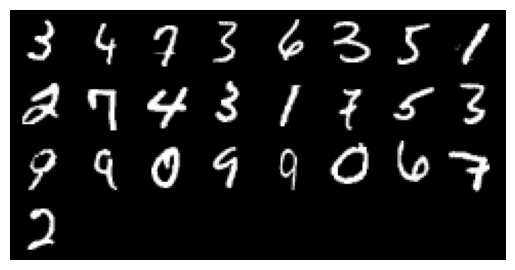

In [ ]:
'''
Plotting the inputs
'''

images = x.cpu()

img_min, img_max = images.min(), images.max()

img_norm = (images - img_min) / (img_max - img_min)

imshow(torchvision.utils.make_grid(img_norm))

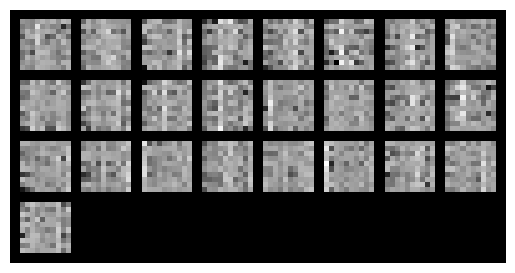

In [ ]:
'''
Plotting the activations of the pooling layer
'''

w = activation['classification_out'].cpu()

w_min, w_max = w.min(), w.max()
plt_weights = (w - w_min) / (w_max - w_min)

plt_weights = plt_weights.reshape(plt_weights.shape[0], -1, 10, 10)

imshow(torchvision.utils.make_grid(plt_weights))

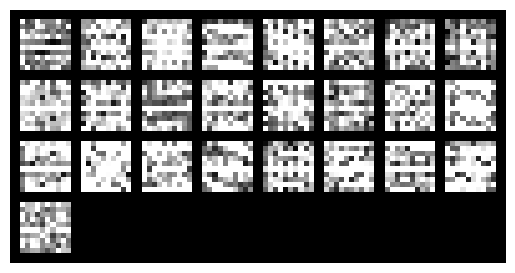

In [ ]:
'''
Plotting the FFT2D of the activations of the pooling layer
'''

w_bfft = activation['classification_out'].cpu()

w_bfft_min, w_bfft_max = w_bfft.min(), w_bfft.max()
w_bfft_norm = (w_bfft - w_bfft_min) / (w_bfft_max - w_bfft_min )

plt_weights_fft = w_bfft_norm.reshape(w_bfft_norm.size()[0], -1, 10, 10)

fft_image = torch.fft.fft2(plt_weights_fft)
# Shift the zero frequency component to the center of the spectrum
fft_image_shifted = torch.fft.fftshift(fft_image)

# Calculate the magnitude spectrum
magnitude_spectrum = torch.abs(fft_image_shifted)

# Display the magnitude spectrum
imshow(torchvision.utils.make_grid(magnitude_spectrum))